In [1]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
import seaborn as sns

In [2]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [3]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r',  'NPCr2cm-cluster', 'NPCr2cm-surface']
n_voxels = [0, 1, 100]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/1260 [00:00<?, ?it/s]

In [4]:
pred = pd.concat(pred)
pdf = pd.concat(pdfs)
df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93522/884262180.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93522/2388943738.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 67)` for the same effect.

  g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=tmp.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, ci=67)


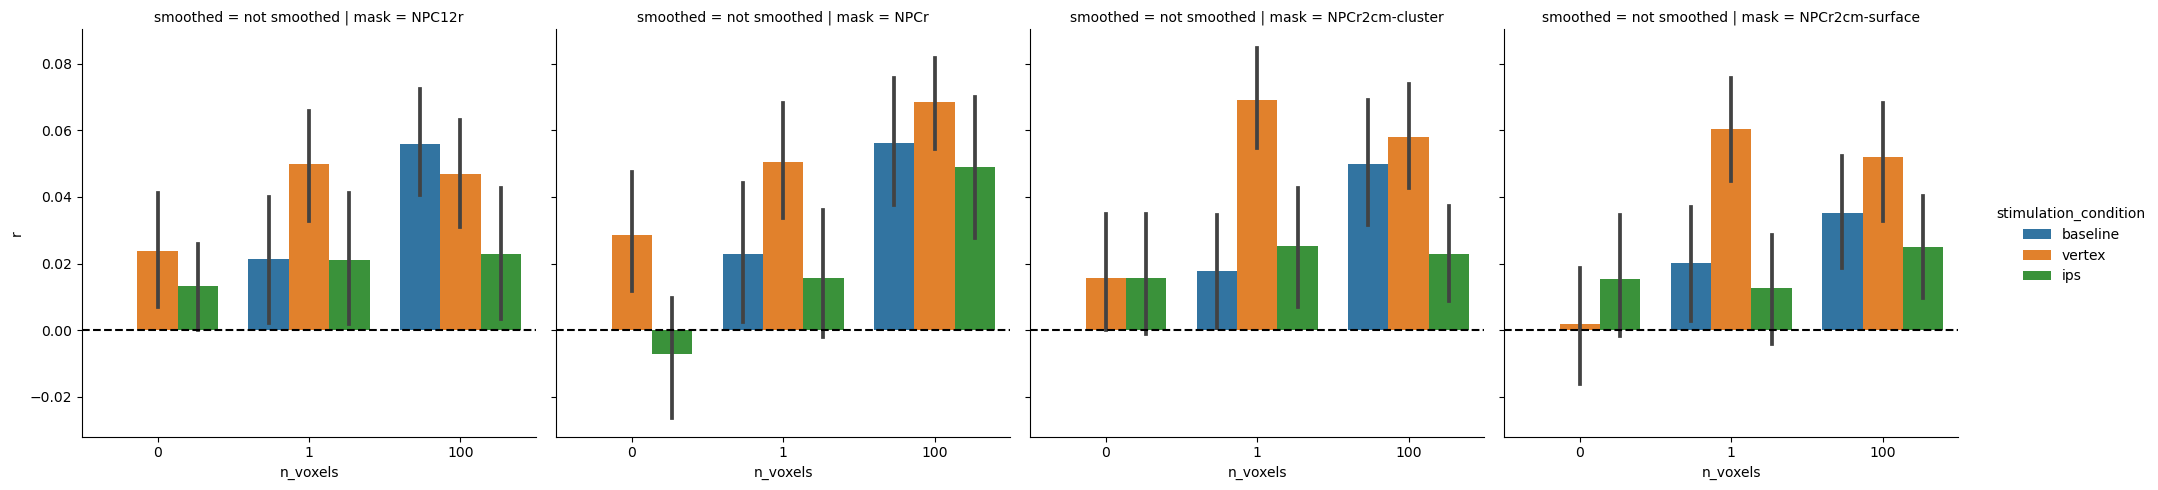

In [5]:
tmp = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['n1'], d['sd']))

g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=tmp.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, ci=67)
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

In [6]:
import bambi

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
tmp = pred.xs(1, 0, 'n_voxels').xs('NPCr2cm-cluster', 0, 'mask').drop('baseline', level='stimulation_condition')

model = bambi.Model('sd ~ n1*stimulation_condition + (n1*stimulation_condition|subject)', tmp.reset_index())

idata = model.fit(draws=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, n1, stimulation_condition, n1:stimulation_condition, 1|subject_sigma, 1|subject_offset, n1|subject_sigma, n1|subject_offset, stimulation_condition|subject_sigma, stimulation_condition|subject_offset, n1:stimulation_condition|subject_sigma, n1:stimulation_condition|subject_offset, sd_sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93522/3162300108.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['n1'])


<xarray.DataArray 'n1' ()>
array(0.91475)

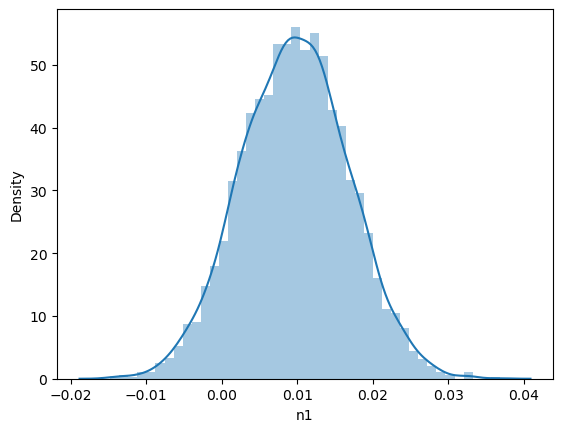

In [8]:
sns.distplot(idata.posterior['n1'])

(idata.posterior['n1'] > 0.0).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93522/2384549889.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['n1:stimulation_condition'])


<xarray.DataArray 'n1:stimulation_condition' ()>
array(0.96025)

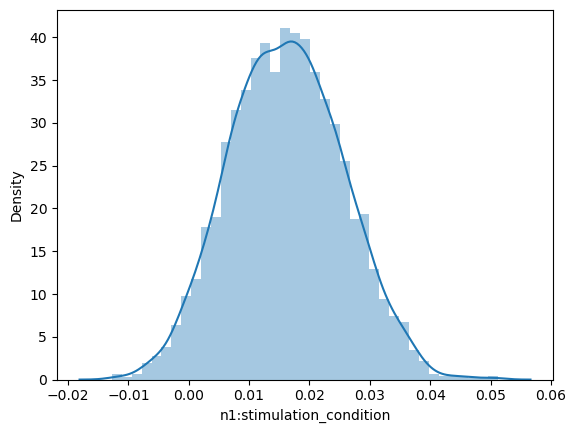

In [9]:
sns.distplot(idata.posterior['n1:stimulation_condition'])

(idata.posterior['n1:stimulation_condition'] > 0.0).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93522/1092510493.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['stimulation_condition'])


<xarray.DataArray 'n1:stimulation_condition' ()>
array(0.03975)

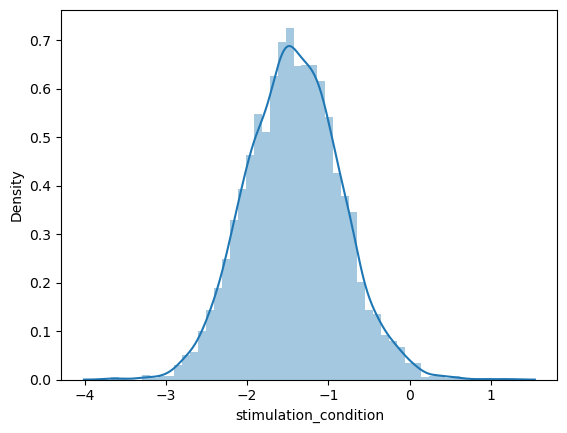

In [10]:
sns.distplot(idata.posterior['stimulation_condition'])

(idata.posterior['n1:stimulation_condition'] < 0.0).mean()

In [25]:
mean_dm_shift = idata.posterior['n1:stimulation_condition|subject'].to_dataframe().groupby('subject__factor_dim').mean()
mean_dm_shift.index = mean_dm_shift.index.rename('subject').astype(int)

In [12]:
import arviz as az
from bauer.utils.math import softplus_np

bids_folder  = '/data/ds-tmsrisk'

model1_idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-1_trace.netcdf'))

n1_evidence_sd = model1_idata.posterior['n1_evidence_sd'].to_dataframe().groupby(['subject', 'n1_evidence_sd_regressors']).mean()
n2_evidence_sd = model1_idata.posterior['n2_evidence_sd'].to_dataframe().groupby(['subject', 'n2_evidence_sd_regressors']).mean()

n1_evidence_sd_ips = softplus_np(n1_evidence_sd.xs('Intercept', 0, 'n1_evidence_sd_regressors'))
n1_evidence_sd_vertex = softplus_np(n1_evidence_sd.xs('Intercept', 0, 'n1_evidence_sd_regressors') + n1_evidence_sd.xs('stimulation_condition[T.vertex]', 0, 'n1_evidence_sd_regressors'))
n2_evidence_sd_ips = softplus_np(n2_evidence_sd.xs('Intercept', 0, 'n2_evidence_sd_regressors'))
n2_evidence_sd_vertex = softplus_np(n2_evidence_sd.xs('Intercept', 0, 'n2_evidence_sd_regressors') + n2_evidence_sd.xs('stimulation_condition[T.vertex]', 0, 'n2_evidence_sd_regressors'))

n1_evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex), keys=['ips', 'vertex'], names=['stimulation_condition'], axis=1)
n2_evidence_sd = pd.concat((n2_evidence_sd_ips, n2_evidence_sd_vertex), keys=['ips', 'vertex'], names=['stimulation_condition'], axis=1)

total_evidence_sd = n1_evidence_sd.loc[:, (slice(None), 'n1_evidence_sd')].droplevel(1, 1) + n2_evidence_sd.loc[:, (slice(None), 'n2_evidence_sd')].droplevel(1, 1)

n1_evidence_sd_diff = n1_evidence_sd['ips'] - n1_evidence_sd['vertex']
n2_evidence_sd_diff = n2_evidence_sd['ips'] - n2_evidence_sd['vertex']
total_evidence_sd_diff = (total_evidence_sd['ips'] - total_evidence_sd['vertex']).to_frame('total_evidence_sd')

In [32]:
n2_evidence_sd_diff.join(mean_dm_shift).join(n1_evidence_sd_diff).join(total_evidence_sd_diff).corr()

,n2_evidence_sd,n1:stimulation_condition|subject,n1_evidence_sd,total_evidence_sd
n2_evidence_sd,1.000000,-0.139092,0.022758,0.165679
n1:stimulation_condition|subject,-0.139092,1.000000,0.096338,0.075109
n1_evidence_sd,0.022758,0.096338,1.000000,0.989695
total_evidence_sd,0.165679,0.075109,0.989695,1.000000


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93522/3953222605.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(x='n1', y='sd', hue='stimulation_condition', data=tmp[np.in1d(tmp.n1, [5, 7, 10, 14, 20, 28])].groupby(['subject', 'stimulation_condition', 'n1']).mean().reset_index(), kind='point', errorbar='se')


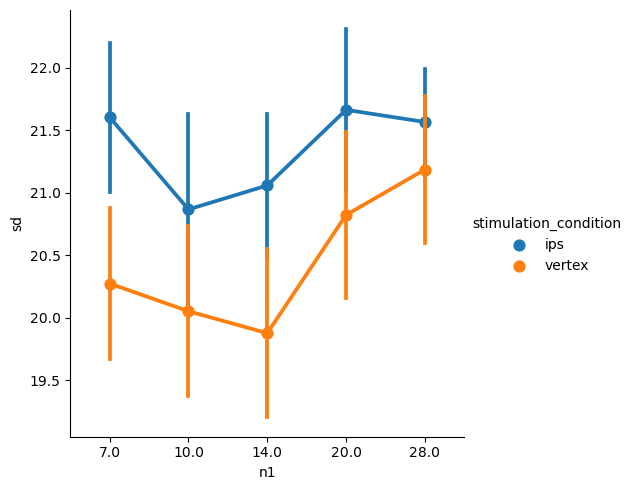

In [13]:
sns.catplot(x='n1', y='sd', hue='stimulation_condition', data=tmp[np.in1d(tmp.n1, [5, 7, 10, 14, 20, 28])].groupby(['subject', 'stimulation_condition', 'n1']).mean().reset_index(), kind='point', errorbar='se')

In [14]:
tmp['error'] = tmp['E'] - tmp['n1']
tmp['abs(error)'] = np.abs(tmp['error'])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93522/3649139744.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(x='n1', y='error', hue='stimulation_condition', data=tmp[np.in1d(tmp.n1, [5, 7, 10, 14, 20, 28])].groupby(['subject', 'stimulation_condition', 'n1']).mean().reset_index(), kind='point', errorbar='se')


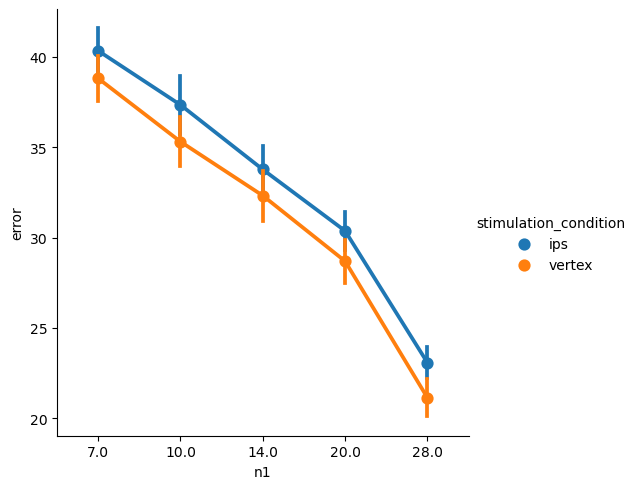

In [15]:
sns.catplot(x='n1', y='error', hue='stimulation_condition', data=tmp[np.in1d(tmp.n1, [5, 7, 10, 14, 20, 28])].groupby(['subject', 'stimulation_condition', 'n1']).mean().reset_index(), kind='point', errorbar='se')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93522/243333995.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(x='n1', y='abs(error)', hue='stimulation_condition', data=tmp[np.in1d(tmp.n1, [5, 7, 10, 14, 20, 28])].groupby(['subject', 'stimulation_condition', 'n1']).mean().reset_index(), kind='point', errorbar='se')


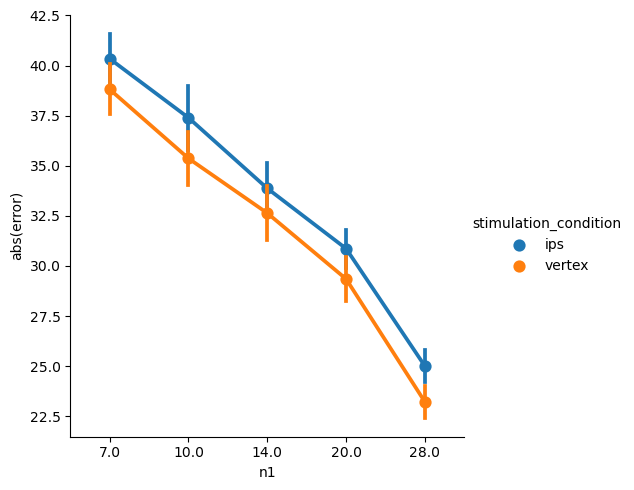

In [16]:
sns.catplot(x='n1', y='abs(error)', hue='stimulation_condition', data=tmp[np.in1d(tmp.n1, [5, 7, 10, 14, 20, 28])].groupby(['subject', 'stimulation_condition', 'n1']).mean().reset_index(), kind='point', errorbar='se')